# League of Legends Early Game Classification Analysis

* Student name: Johnny Dryman
* Student pace: full time
* Scheduled project review date/time: 5/27/2021
* Instructor name: James Irving

## Business Problem

League of Legends (LoL) is an intensely competitive game designed for 'core' gamers, or gamers who care deeply about winning the game.  Naturally, these players hate losing.  When I first started playing, I noticed that one of my teammates might "rage quit" a game within the first 10-20 minutes, leaving my teammates and I to an inevitable failure.  This made my experience suffer, and I could see my teammates lamenting in the chat as well.  Considering a single game of LoL can last for 45 minutes, the remaining 35 minutes was not an enjoyable experience.

When I discovered the dataset for League of Legends matches with only the first 10 minutes of data, I was inspired to try and find out whether or not my angry teammates were justified in rage quitting.  Was too much of the 45 minute game decided within the first 10 minutes?  Can I use machine learning to predict the winner with only 10 minutes of data?  What factors in the early game were most likely to lead to a victory?

The goal of this project is to take a look at how well a winner can be predicted based on early game information, and it also seeks to understand what specific factors can predict a victory.

# Data Import and Processing

This data was sourced from Kaggle, where a user posted the first 10 minutes of data pulled from the League of Legends API.  The data represents 9,879 games from Diamond ranked players.  

Importing packages for importing data and exploratory visual analysis.

In [1]:
#Standard python libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings(action='ignore') 

# Preprocessing tools
from sklearn.model_selection import train_test_split,cross_val_predict,cross_validate
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
scaler = StandardScaler()
from sklearn import metrics

# Models & Utilities
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Warnings
import warnings
warnings.filterwarnings(action='ignore') 



This data was found on Kaggle: https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min

In [2]:
# Importing data
df = pd.read_csv('data/high_diamond_ranked_10min.csv')

df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [3]:
# Taking a look at our columns
print(df.info())

# Checking for NA data
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

Fortunately there are no null values in our dataset.

There are a few columns that can be removed entirely and a few that can be combined into categorical variables.

### First Blood

'First Blood' is awarded to the team who gets the first kill in the game.  Both blueFirstBlood and redFirstBlood are binary and inversely related.  If Blue wins First Blood, blueFirstBlood will be recorded as 1 and redFirstBlood will be recorded as 0.  

We can merge these columns into one.

In [4]:
df['blueFirstBlood'].head()

0    1
1    0
2    0
3    0
4    0
Name: blueFirstBlood, dtype: int64

In [5]:
firstBlood = []
for item in df['blueFirstBlood']:
    if item == 1:
        firstBlood.append('Blue')
    else:
        firstBlood.append('Red')        
df['firstBlood'] = firstBlood

df['firstBlood'].head()

0    Blue
1     Red
2     Red
3     Red
4     Red
Name: firstBlood, dtype: object

We can discard blueFirstBlood and redFirstBlood

In [6]:
df = df.drop(['blueFirstBlood','redFirstBlood'], axis=1)

### Kills & Deaths

blueKills is inversely related with redDeaths, and redKills is inversely related with blueDeaths since the Blue team can only kill Red players and vice versa.  blueDeaths and redDeaths can both be removed, leaving kills intact will preserve this information.

In [7]:
df = df.drop(['blueDeaths','redDeaths'], axis=1)

### Dragon & Herald

While this wouldn't hold true for LoL data spanning the entire length of each game, we know that there is only one opportunity to kill both the Dragon and the Harold in the first 10 minutes of each match.  Unlike firstBlood where the action always occurs in the first 10 minutes (at least for the matches in our dataset), each dragon or herald can be killed only once or not at all.

Therefore, dragon and herald can be categorized as 'Blue,' 'Red,' or 'None.'

In [8]:
dragon_list = []

dragon_kill = df['blueDragons'] - df['redDragons']

for item in dragon_kill:
    if item == 1:
        dragon_list.append('Blue')
    elif item == -1:
        dragon_list.append('Red')
    else:
        dragon_list.append('No Dragon')
        
df['dragon'] = dragon_list

blueDragons and redDragons can be removed:

In [9]:
df = df.drop(['blueDragons','redDragons'], axis=1)

We can reuse this code for the herald feature:

In [10]:
herald_list = []

herald_kill = df['blueHeralds'] - df['redHeralds']

for item in herald_kill:
    if item == 1:
        herald_list.append('Blue')
    elif item == -1:
        herald_list.append('Red')
    else:
        herald_list.append('No Herald')
        
df['herald'] = herald_list

In [11]:
df = df.drop(['blueHeralds','redHeralds'], axis=1)

### Elite Monsters

In the first 10 minutes of a match, Elite Monsters will receive +1 if a team kills the Dragon and another +1 if the same team kills the Herald.  It is redundant information from what we already have with the Dragon and Harold features.  

In [12]:
df = df.drop(['blueEliteMonsters','redEliteMonsters'], axis=1)

### GoldDiff, ExperienceDiff, CSPerMin, and GoldPerMin

Both blue and red teams have these four metrics.  While they are useful metrics for other types of analyses, they are essentially duplicative, since they are all calculated in a similar fashion from features already included in our data.  

- GoldDiff represents the difference between blueTotalGold and redTotalGold
- ExperienceDiff represents the difference between blueTotalExperience and redTotalExperience
- blue and red CSPerMin represents the minute rate of blue and red TotalMinionsKilled.  For our 10 minute data, CSPerMin for each team will always be TotalMinionsKilled divided by 10
- similarly, blue and red GoldPerMin represents blue and red TotalGold divided by 10

These four features from both teams (totaling 8 features) can be removed without losing any information.


In [13]:
df = df.drop(['blueGoldDiff',
            'blueExperienceDiff',
            'blueCSPerMin',
            'blueGoldPerMin',
            'redGoldDiff',
            'redExperienceDiff',
            'redCSPerMin',
            'redGoldPerMin'], axis=1)

### gameId

gameId represents a unique identifier for every LoL game, no two gameId's will ever be the same, so this column can be removed.

In [14]:
df = df.drop(['gameId'], axis=1)

### Merging Continuous Features

For this analysis, we will combine all blue and red continuous features into single features that will represent that +/- ratio of blue compared to red.  If a continuous value is positive, that means blue had that much more than red.  If a feature is negative, the absolute value of that negative number represents red's greater value.  

In [15]:
# Saving copy of dataframe so far before merging continuous features
df_blue_red = df.copy()

# Instantiating empty dataframe
diff_df = pd.DataFrame()

# Building diff_df by calculating differences between blue and red stats
diff_df['WardsPlaced'] = df['blueWardsPlaced'] - df['redWardsPlaced']
diff_df['WardsDestroyed'] = df['blueWardsDestroyed'] - df['redWardsDestroyed']
diff_df['Kills'] = df['blueKills'] - df['redKills']
diff_df['Assists'] = df['blueAssists'] - df['redAssists']
diff_df['TowersDestroyed'] = df['blueTowersDestroyed'] - df['redTowersDestroyed']
diff_df['TotalGold'] = df['blueTotalGold'] - df['redTotalGold']
diff_df['AvgLevel'] = df['blueAvgLevel'] - df['redAvgLevel']
diff_df['TotalExperience'] = df['blueTotalExperience'] - df['redTotalExperience']
diff_df['TotalMinionsKilled'] = df['blueTotalMinionsKilled'] - df['redTotalMinionsKilled']
diff_df['TotalJungleMinionsKilled'] = df['blueTotalJungleMinionsKilled'] - df['redTotalJungleMinionsKilled']

# Merging with categorical features
diff_df = pd.concat([diff_df, df[['firstBlood', 'dragon', 'herald', 'blueWins']]], axis=1)

diff_df.head()

,WardsPlaced,WardsDestroyed,Kills,Assists,TowersDestroyed,TotalGold,AvgLevel,TotalExperience,TotalMinionsKilled,TotalJungleMinionsKilled,firstBlood,dragon,herald,blueWins
0,13,-4,3,3,0,643,-0.2,-8,-2,-19,Blue,No Dragon,No Herald,0
1,0,0,0,3,-1,-2908,-0.2,-1173,-66,-9,Red,Red,Red,0
2,0,-3,-4,-10,0,-1172,-0.4,-1033,-17,18,Red,Blue,No Herald,0
3,28,-1,-1,-5,0,-1321,0.0,-7,-34,8,Red,No Dragon,Blue,0
4,58,2,0,-1,0,-1004,0.0,230,-15,-10,Red,Red,No Herald,0


# Exploratory Analysis

## Visualizations

Let's run a few visualizations to help us understand the data.  We will use our diff_df, since it's a bit easier to interpret the results.

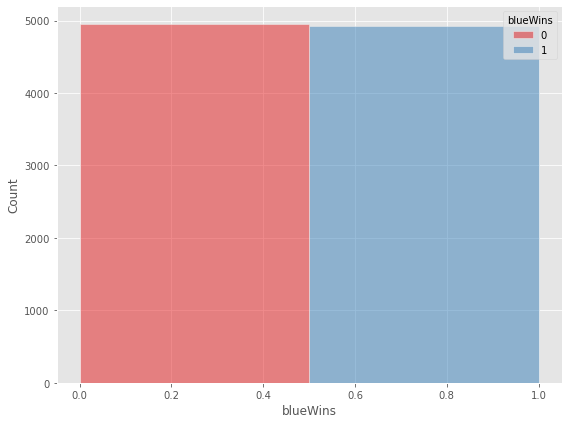

In [16]:
# Set style
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Plot histogram
fig, ax = plt.subplots(figsize=(8,6))
fig.tight_layout()
sns.histplot(x='blueWins', data=diff_df, hue='blueWins', palette='Set1',bins=(2), kde=False)

# Save as image
plt.tight_layout()
plt.savefig('images/win_counts.png')

In [17]:
import matplotlib as mpl

# Check total count for blue wins and losses
df['blueWins'].value_counts()

0    4949
1    4930
Name: blueWins, dtype: int64

The win split seems pretty even, so it seems there is no overt advantage to being either blue or red.

<AxesSubplot:xlabel='Kills', ylabel='Count'>

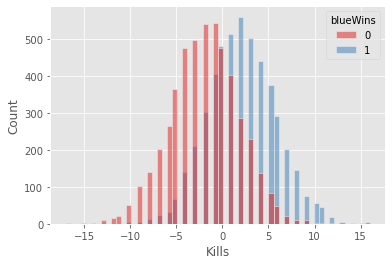

In [18]:
sns.histplot(x='Kills', data=diff_df, hue='blueWins', palette='Set1')

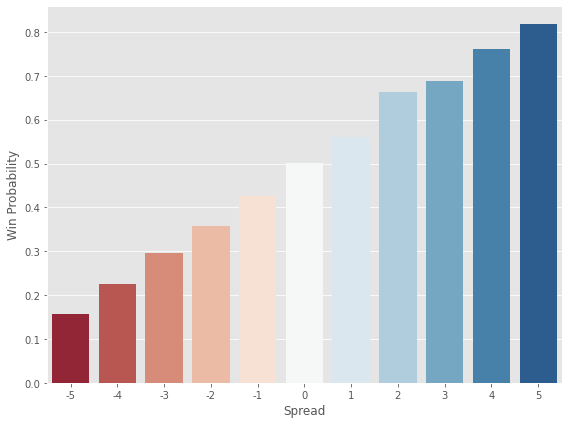

In [19]:
kill_spread = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]

df_kill_spread_means = []

for x in kill_spread:

    df_blue = df[(df['blueKills'] - df['redKills']) == x]
    
    df_kill_spread_means.append(df_blue['blueWins'].mean())

df_kill_spread_means = {'Spread':kill_spread,'Win Probability':df_kill_spread_means}

df_kill_spread_means = pd.DataFrame(df_kill_spread_means)
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(x="Spread", y="Win Probability", data=df_kill_spread_means, palette='RdBu')
fig.tight_layout()
plt.savefig('images/kill_spread.png')

It seems clear that outperforming in kills has an influence on winning.

<AxesSubplot:xlabel='Assists', ylabel='Count'>

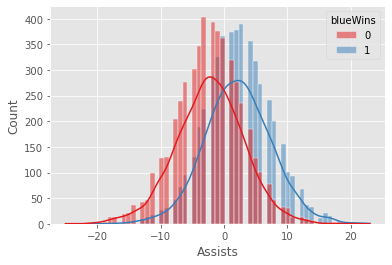

In [20]:
sns.histplot(x='Assists', data=diff_df, hue='blueWins', palette='Set1', kde=True)

Assists still seem relevant and are also somewhat incidental to kills, but the disparity with assists is less clear.

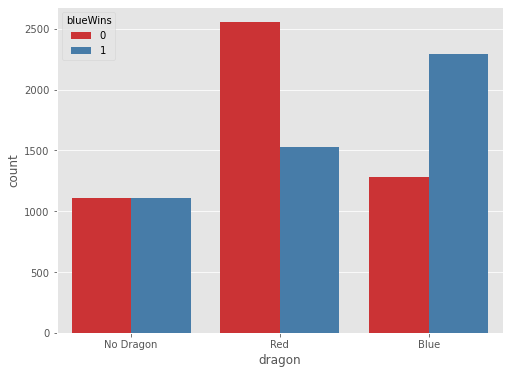

In [21]:
# sns.countplot(x='dragon', data=diff_df, hue='blueWins', palette='Set1')

# Set style
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Plot histogram
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(x='dragon', data=diff_df, hue='blueWins', palette='Set1')

# Save as image
plt.savefig('images/dragon.png')

In [22]:
blue_dragon_win = diff_df[(diff_df['dragon'] == 'Blue') 
                                & (diff_df['blueWins'] == 1)].shape[0]

blue_dragon_loss = diff_df[(diff_df['dragon'] == 'Blue') 
                                & (diff_df['blueWins'] == 0)].shape[0]

blue_dragon_total = blue_dragon_win + blue_dragon_loss

print(f'Blue dragon wins: {blue_dragon_win}, {blue_dragon_win/blue_dragon_total}')
print(f'Blue dragon loss: {blue_dragon_loss}, {blue_dragon_loss/blue_dragon_total}')

Blue dragon wins: 2292, 0.6409395973154363
Blue dragon loss: 1284, 0.35906040268456374


Killing the dragon in the first 10 minutes seems to have a positive influence on winning.  While it might be telling of a win, there are plenty of instances where blue kills the dragon, but red kills the game.  

It's interesting that in the event of no dragon being killed, the victory split for blue and red are nearly identical.

<AxesSubplot:xlabel='herald', ylabel='count'>

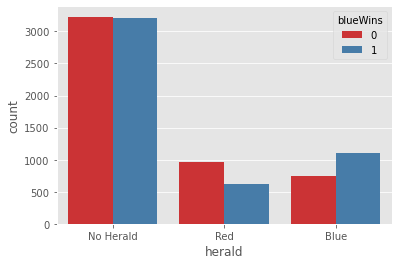

In [23]:
sns.countplot(x='herald', data=diff_df, hue='blueWins', palette='Set1')

There's still an impact for killing the Herald, but it isnt' nearly as significant.  It's also not incredibly common within the first 10 minutes.

<AxesSubplot:xlabel='firstBlood', ylabel='count'>

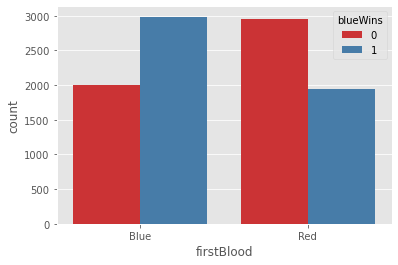

In [24]:
sns.countplot(x='firstBlood', data=diff_df, hue='blueWins', palette='Set1')

First blood is also a notable influencer on victory, but it isn't quite as strong as killing the dragon

<AxesSubplot:xlabel='TotalGold', ylabel='Count'>

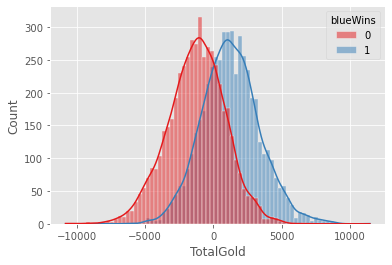

In [25]:
sns.histplot(x='TotalGold', data=diff_df, hue='blueWins', palette='Set1', kde=True)

Gold is also an indicator of victory.  Based on just the graph, it doesn't appear to influnce victory more than kills or assists.

<AxesSubplot:xlabel='WardsPlaced', ylabel='Count'>

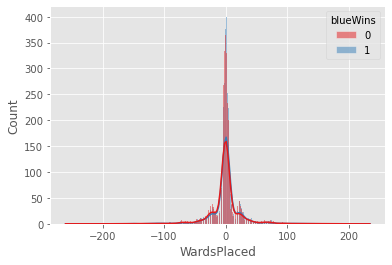

In [26]:
sns.histplot(x='WardsPlaced', data=diff_df, hue='blueWins', palette='Set1', kde=True)

The spread on Wards doesn't seem too telling of a victory.  There's also a significant amount of outliers.

## Multicollinearity

(<Figure size 1080x720 with 2 Axes>, <AxesSubplot:>)

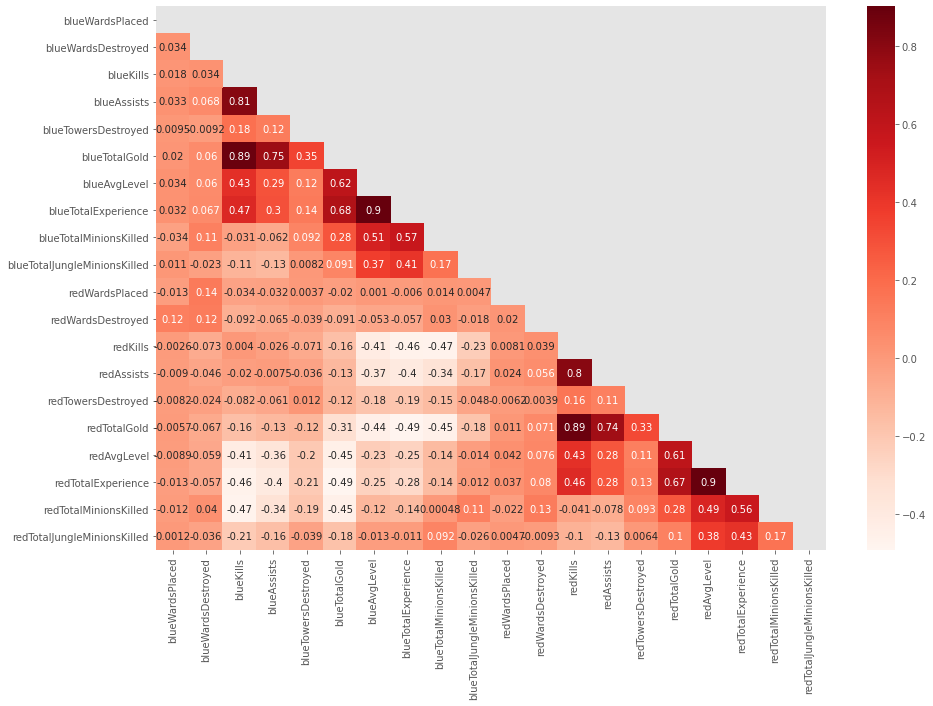

In [27]:
# Create function to output multicollinearity heatmap
def heatmap(df_name, figsize=(15,10), cmap='Reds'):
    corr = df_name.drop('blueWins',axis=1).corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, annot=True, cmap=cmap, mask=mask)
    return fig, ax

heatmap(df)

At first glance, it looks like Gold and Experience / AvgLevel are highly correlated with multiple features.

In [28]:
# Create function to display correlations
# https://pydatascience.org/2019/07/23/remove-duplicates-from-correlation-matrix-python/
def corr_list(df):
    dataCorr = df.drop('blueWins',axis=1).corr()
    dataCorr = dataCorr[abs(dataCorr) >= 0.01].stack().reset_index()
    dataCorr = dataCorr[dataCorr['level_0'].astype(str)!=dataCorr['level_1'].astype(str)]
    dataCorr['ordered-cols'] = dataCorr.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
    dataCorr = dataCorr.drop_duplicates(['ordered-cols'])
    dataCorr.drop(['ordered-cols'], axis=1, inplace=True)

    return dataCorr.sort_values(by=[0], ascending=False).head(10) #Get 10 highest correlation of pairwaise attributes

corr_list(df)


,level_0,level_1,0
298,redAvgLevel,redTotalExperience,0.901748
113,blueAvgLevel,blueTotalExperience,0.901297
37,blueKills,blueTotalGold,0.888751
224,redKills,redTotalGold,0.885728
35,blueKills,blueAssists,0.813667
222,redKills,redAssists,0.804023
56,blueAssists,blueTotalGold,0.748352
242,redAssists,redTotalGold,0.736215
93,blueTotalGold,blueTotalExperience,0.676193
279,redTotalGold,redTotalExperience,0.669646


Our multicollinearity analysis has presented a few variable relationships that need additional consideration.

- avgLevel and TotalExperience are highly correlated, which is not surprising.  We will keep both for now, but we will also be removing these later in our logistic regression analysis.  
- TotalGold appears consistently in our list.  This is also not surprising since kills and assists award gold.  We will experiment with removing TotalGold for feature analysis.

# MODEL

## Train Test Split

In [29]:
# Isolate target and features
y = df['blueWins']
X = df.drop(columns=['blueWins'], axis=1)

# Create train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

# Confirm split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (6915, 23)
X_test shape: (2964, 23)


### Categorical Columns

In [30]:
# Separate feautures into continuous and categorical
categoricals = X.select_dtypes('O').columns
numericals = X.select_dtypes('number').columns

# Check output
categoricals, numericals

(Index(['firstBlood', 'dragon', 'herald'], dtype='object'),
 Index(['blueWardsPlaced', 'blueWardsDestroyed', 'blueKills', 'blueAssists',
        'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
        'blueTotalExperience', 'blueTotalMinionsKilled',
        'blueTotalJungleMinionsKilled', 'redWardsPlaced', 'redWardsDestroyed',
        'redKills', 'redAssists', 'redTowersDestroyed', 'redTotalGold',
        'redAvgLevel', 'redTotalExperience', 'redTotalMinionsKilled',
        'redTotalJungleMinionsKilled'],
       dtype='object'))

In [31]:
# Encode categorical columns, only drop if binary
encoder = OneHotEncoder(sparse=False,drop=None)
train_categoricals = encoder.fit_transform(X_train[categoricals])
test_categoricals = encoder.transform(X_test[categoricals])

# Check output
train_categoricals

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [32]:
# Convert train and test categoricals into dataframes for merge

train_categoricals_df = pd.DataFrame(train_categoricals,
                                     columns=encoder.get_feature_names(categoricals))

test_categoricals_df =  pd.DataFrame(test_categoricals,
                                     columns=encoder.get_feature_names(categoricals))

# Check output
train_categoricals_df.head()

,firstBlood_Blue,firstBlood_Red,dragon_Blue,dragon_No Dragon,dragon_Red,herald_Blue,herald_No Herald,herald_Red
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


### Numerical Columns

In [33]:
# Scale continuous features and combine into dataframe for merge

scaler = StandardScaler()

train_numericals_df = pd.DataFrame(scaler.fit_transform(X_train[numericals]),
                              columns=numericals)

test_numericals_df = pd.DataFrame(scaler.transform(X_test[numericals]),
                              columns=numericals)

train_numericals_df.head()

,blueWardsPlaced,blueWardsDestroyed,blueKills,blueAssists,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,redWardsPlaced,redWardsDestroyed,redKills,redAssists,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled
0,-0.578888,0.989647,0.933960,0.085648,-0.213734,0.752820,0.267110,0.231218,-0.718868,2.169900,-0.121349,-0.821497,0.644436,0.584197,-0.192021,0.782592,1.560938,1.014104,1.359504,0.077538
1,-0.069037,-0.372949,0.270955,-0.161126,-0.213734,0.163934,-0.385794,-0.068853,-0.489088,0.046285,-0.285904,0.613736,-0.036795,-0.156946,-0.192021,0.899375,0.906406,0.806784,0.626710,1.677757
2,-0.352287,-0.372949,-0.392050,-0.161126,-0.213734,-0.511020,-1.038697,-0.807360,-0.948648,0.956405,-0.340756,0.135325,0.644436,0.337150,-0.192021,-0.073146,-0.402658,-0.020825,0.214513,-2.022750
3,-0.125687,1.898045,1.596965,2.306620,-0.213734,2.111789,0.920013,0.980562,0.705769,-0.257089,-0.340756,0.135325,-1.399258,-1.145137,-0.192021,-1.222855,-1.711722,-1.652635,-1.205276,1.277702
4,-0.465588,0.081250,-0.060548,-0.161126,-0.213734,-0.162866,0.267110,0.412094,0.384077,-1.167209,-0.395608,0.135325,-1.058642,-0.651041,-0.192021,-0.799348,0.251874,-0.225637,-0.747279,0.477592


In [34]:
# Recombine transformed categorical and continuous features, print shape
X_train = pd.concat([train_numericals_df, train_categoricals_df], axis=1)
X_test = pd.concat([test_numericals_df, test_categoricals_df], axis=1)

# Check shape
print(X_train.shape)
print(X_test.shape)

(6915, 28)
(2964, 28)


## Logistic Regression

In [35]:
# Initiate and train model
model_log = LogisticRegression(random_state=8)
model_log.fit(X_train, y_train)

LogisticRegression(random_state=8)

In [36]:
# Test for class imbalance
print(y_train.value_counts(1))
print(y_test.value_counts(1))

1    0.500217
0    0.499783
Name: blueWins, dtype: float64
0    0.503711
1    0.496289
Name: blueWins, dtype: float64


### Accuracy

In [37]:
# Create function for efficient accuracy checks
def model_accuracy(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    print(f'Training Accuracy: {model.score(X_train,y_train):.2%}')
    print(f'Test Accuracy: {model.score(X_test,y_test):.2%}')

model_accuracy(model_log)

Training Accuracy: 74.04%
Test Accuracy: 71.83%


### Cross Validation Check

In [38]:
# Create cross validation function 
def cross_val_check(model_string_name, model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    scores = cross_val_score(model, X_train, y_train, cv=10) # model, train, target, cross validation
    print(f'{model_string_name} Cross Validation Scores:\n')
    print(scores)
    print(f'\nCross validation mean: \t{scores.mean():.2%}')
    
cross_val_check('Logistic Regression', model_log)

Logistic Regression Cross Validation Scores:

[0.72543353 0.72976879 0.76011561 0.73265896 0.74421965 0.74819103
 0.72793054 0.74674385 0.72937771 0.73082489]

Cross validation mean: 	73.75%


With the highest score at 75.8% and the lowest at 72.5%, we shouldn't be overly concerned with these varying performances calculated with cross validation.

### Confusion Matrix & Classification Report

To save ourself some coding, we'll create a function to report various model metrics.

In [39]:
def evaluate_model(model, X_train=X_train, X_test=X_test, y_train=y_train, 
                   y_test=y_test, cmap='Greens', normalize='true',
                   classes=None,figsize=(10,4)):
    
    # Print model accuracy
    print(f'Training Accuracy: {model.score(X_train,y_train):.2%}')
    print(f'Test Accuracy: {model.score(X_test,y_test):.2%}')
    print('')
    
    # Print classification report
    y_test_predict = model.predict(X_test)
    print(metrics.classification_report(y_test, y_test_predict,
                                        target_names=classes))
    
    # Plot confusion matrix
    fig,ax = plt.subplots(ncols=2,figsize=figsize)
    metrics.plot_confusion_matrix(model, X_test,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                  ax=ax[0])
    
    #Plot ROC curves
    with sns.axes_style("darkgrid"):
        curve = metrics.plot_roc_curve(model,X_train,y_train,ax=ax[1])
        curve2 = metrics.plot_roc_curve(model,X_test,y_test,ax=ax[1])
        curve.ax_.grid()
        curve.ax_.plot([0,1],[0,1],ls=':')
        fig.tight_layout()
        plt.show()
    
    

Training Accuracy: 74.04%
Test Accuracy: 71.83%

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1493
           1       0.72      0.72      0.72      1471

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



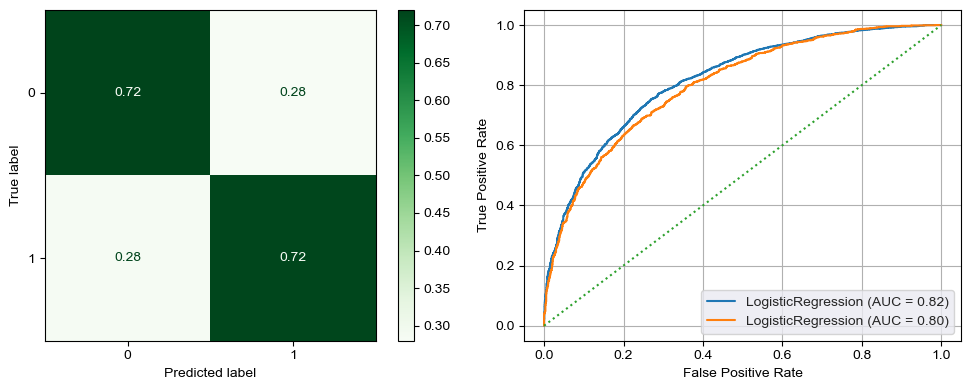

In [40]:
# Reset style for model evaluation plots
mpl.rcParams.update(mpl.rcParamsDefault)

evaluate_model(model_log)

### Dummy Check

It's also important to do a dummy check just to be scientifically certain that we're not arriving at our metrics by chance.

Training Accuracy: 50.76%
Test Accuracy: 49.73%

              precision    recall  f1-score   support

           0       0.52      0.51      0.51      1493
           1       0.51      0.51      0.51      1471

    accuracy                           0.51      2964
   macro avg       0.51      0.51      0.51      2964
weighted avg       0.51      0.51      0.51      2964



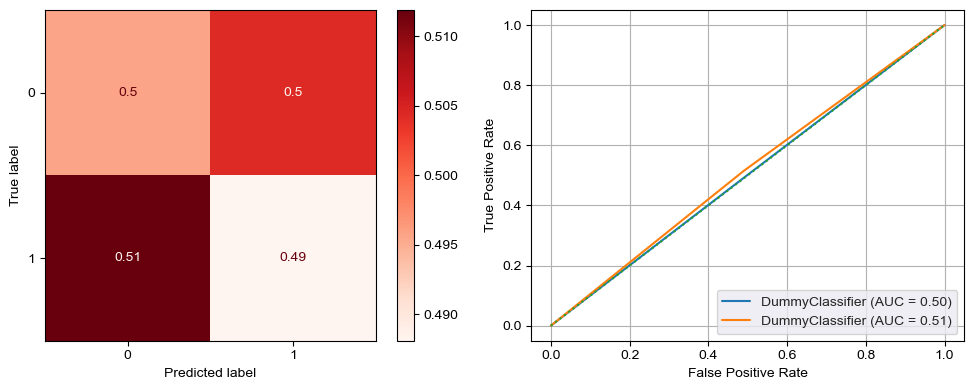

In [41]:
# Create dummy classifier and fit to train / test
dummy = DummyClassifier(strategy='stratified')#,constant=0)
preds = dummy.fit(X_train,y_train).predict(X_test)

evaluate_model(dummy, cmap='Reds')

Based on the dummy, any model we create that performs better than 50% and has a greater AUC than 0.50 would be useful for analysis.

### Grid Search

In [42]:
# Initiate new model and perform grid search
model_log_hp = LogisticRegression(random_state=8)

# Define lists of parameters to compare
params = {'C':[0.001,0.01,0.1,1,10,100,1000],
        'penalty':['l1','l2','elastic_net'],
        'solver':["liblinear", "newton-cg", "lbfgs", "sag","saga"]
         }

# Run the grid search with a focus on accuracy
log_grid_search = GridSearchCV(model_log_hp,params,scoring='accuracy')

# Fit grid search to training data and display best parameters
log_grid_search.fit(X_train, y_train)

# Print best parameters
log_grid_search.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Training Accuracy: 74.16%
Test Accuracy: 72.10%

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1493
           1       0.72      0.72      0.72      1471

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



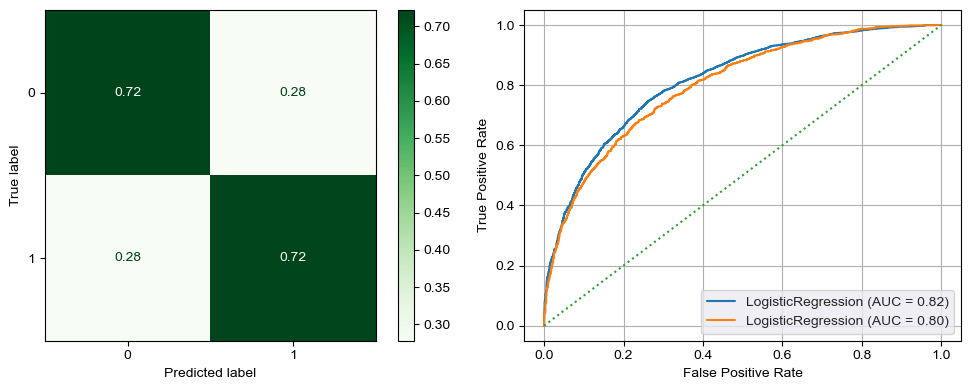

In [43]:
evaluate_model(log_grid_search.best_estimator_)

In [44]:
# Create compare model function

def model_compare(base_model, grid_search_model):
    
    # Calculate accuracies
    base_score = base_model.score(X_test, y_test)
    grid_score = grid_search_model.score(X_test, y_test)
    
    #Print accuracies
    print("--- Base Model ---")
    model_accuracy(base_model)
    print('')
    print("--- Grid Search Model ---")
    model_accuracy(grid_search_model)
    print('')
    
    # If/else function to display best model and score improvement
    if base_score < grid_score:    
        print(f'Our grid search model outperformed our base model by {(grid_score - base_score):.2%}')
    else:
        print(f'Our base model outperformed our grid search model by {(base_score - grid_score):.2%}')
    
model_compare(model_log, log_grid_search.best_estimator_)

--- Base Model ---
Training Accuracy: 74.04%
Test Accuracy: 71.83%

--- Grid Search Model ---
Training Accuracy: 74.16%
Test Accuracy: 72.10%

Our grid search model outperformed our base model by 0.27%


The performance improvement is only marginal, but an improvement nonetheless.  

### Coefficients

Alright!  We can finally dive into the coefficients of our logistic regression model to understand what it believes is most important to predicting the outcome of a match with only 10 minutes worth of data.

Importantly, it can only predict the outcome of a match with 71.83% accuracy.  By comparison, our dummy model was correct 49.49% of the time.  Roughly speaking, this model is ~22% more predictive than flipping a coin.

For analysis, we'll use our basic linear regression model so that we can efficiently recalculate our coefficients as we remove features.

Training Accuracy: 74.04%
Test Accuracy: 71.83%


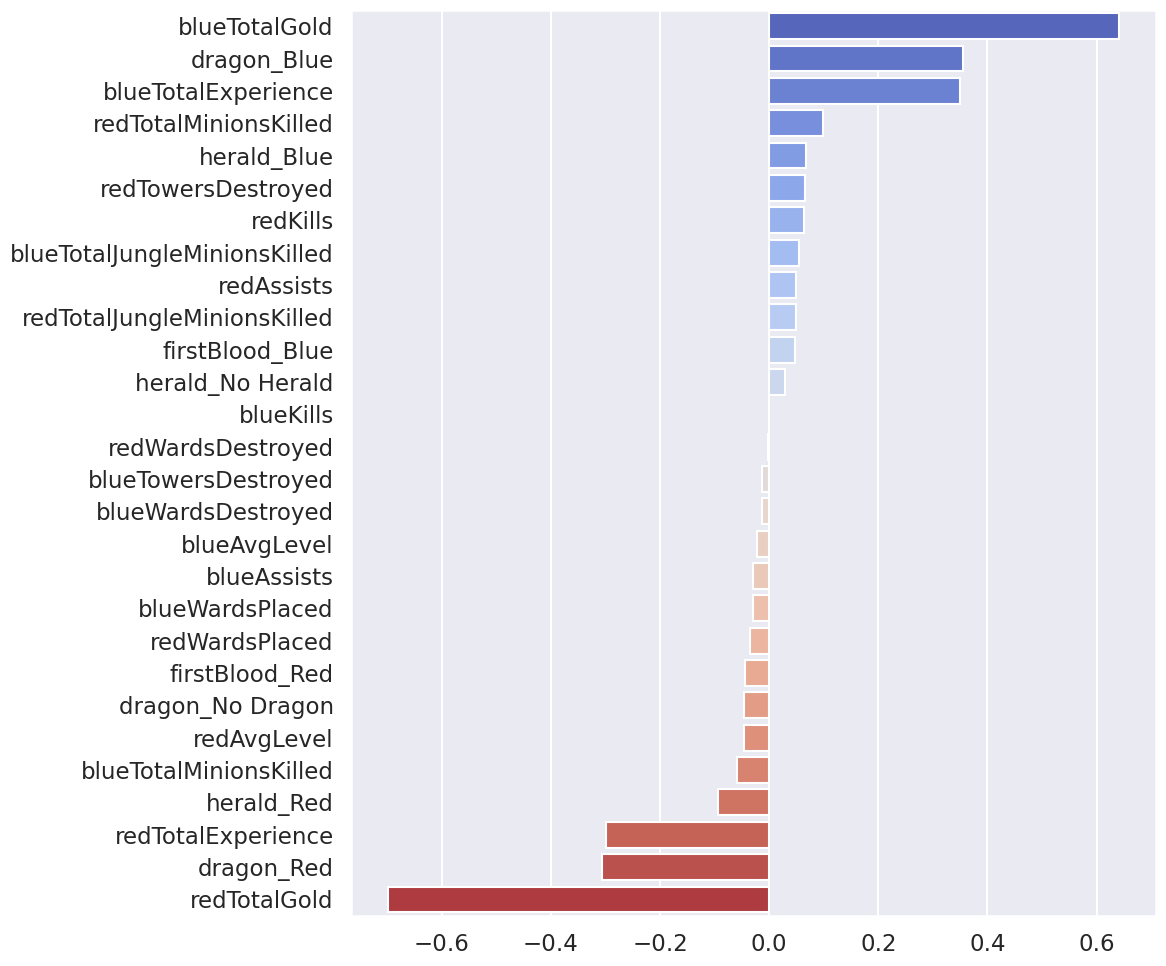

In [64]:
# Create coefficient graph function

# Uncomment line below to create images for presentation
# sns.set_context('talk')

def plot_coefficients(X_train, X_test, y_train=y_train, y_test=y_test, filename='image'):    
    
    # Instantiate and train new model
    model = LogisticRegression(random_state=8)
    model.fit(X_train, y_train)
    
    # Create a list of coefficients
    coeffs = pd.Series(model.coef_.flatten(), index=X_train.columns).sort_values(ascending=False)
    
    # Display accuracy of newly trained model
    model_accuracy(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

    # Create coefficients plot
    with sns.axes_style("darkgrid"):
        plt.figure(figsize=(12, 10))
        ax = sns.barplot(x=coeffs, y=coeffs.index, palette='coolwarm')
    
    # Save image
    plt.tight_layout()
    plt.savefig(f'images/{str(filename)}.png')
    
plot_coefficients(X_train, X_test, filename='coef_all')

Let's first take a look at feature importances using all of our features.

TotalGold is clearly the most predictive feature for victory.  

Earlier, we noticed TotalGold has very high multicollinearity with multiple features.  This isn't surprising, since gold is a resource won from actions taken in the game.  Killing opponents, elite monsters, and creeps all award gold.  

However, it should be pointed out that this model seems to believe that TotalGold will lead to a victory even when Blue is behind in a lot of other key features, like kills, assists, towers, and minions.

This is a bit of a head scratcher.  It's difficult to fathom a situation where blue has more gold than red while also having less kills, assists, and total minions killed.  Perhaps this is a result of our multicollinearity tied to gold and experience.  Let's remove these one by one to see how our coefficients change.

We'll start by dropping TotalGold:

Training Accuracy: 73.32%
Test Accuracy: 71.09%


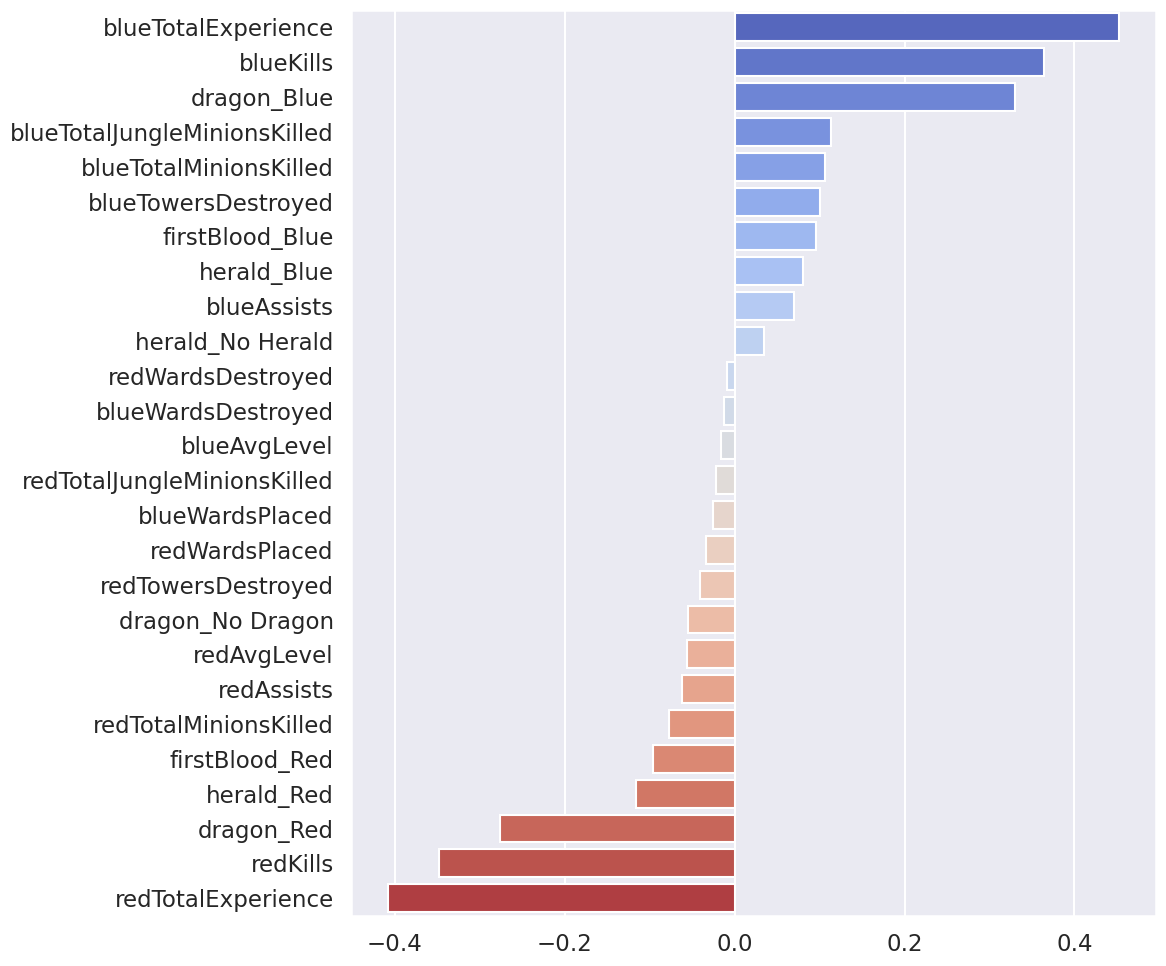

In [65]:
# Drop blue and red TotalGold
X_train_coeff = X_train.drop(['blueTotalGold', 'redTotalGold'],axis=1)
X_test_coeff = X_test.drop(['blueTotalGold', 'redTotalGold'],axis=1)

plot_coefficients(X_train_coeff, X_test_coeff)

These coefficients are a bit more in line with our expectations.  Key in-game performance metrics like kills, dragon, towers, and minions now reflect our general understanding about the game.

TotalExperience is still very high and also correlative with many of our action based metrics.  Let's remove this as well as AvgLevel and see what happens.

Training Accuracy: 72.90%
Test Accuracy: 70.68%


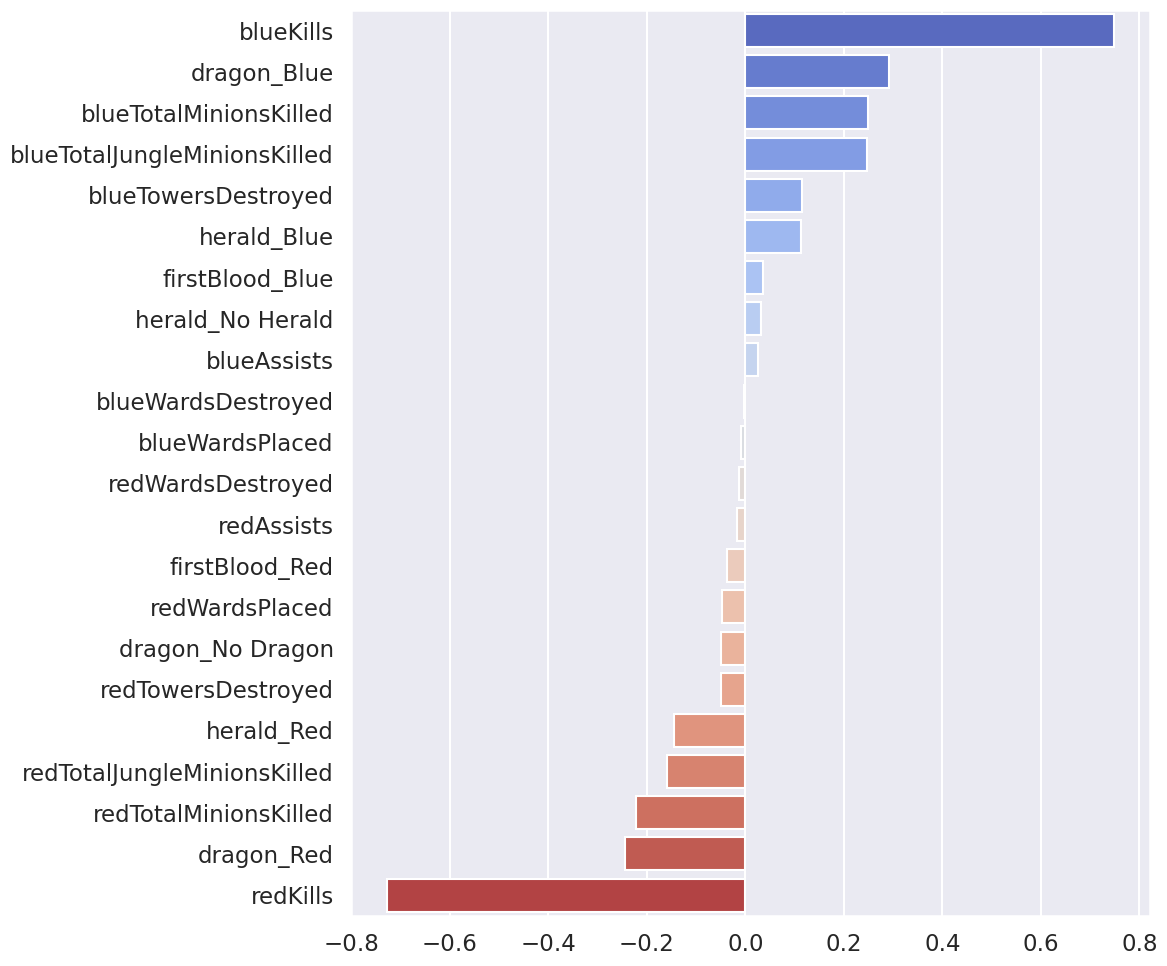

In [66]:
# Drop blue and red TotalGold, TotalExperience, and AvgLevel
X_train_coeff = X_train.drop(['blueTotalGold', 'blueTotalExperience',
                             'redTotalGold', 'redTotalExperience',
                             'blueAvgLevel', 'redAvgLevel'],axis=1)
X_test_coeff = X_test.drop(['blueTotalGold', 'blueTotalExperience',
                             'redTotalGold', 'redTotalExperience',
                             'blueAvgLevel', 'redAvgLevel'],axis=1)

plot_coefficients(X_train_coeff, X_test_coeff, filename='coef_action')

Finally, we have a visual of coefficients exclusively related to in-game actions.  It is likely that our original model gravitated towards gold because it is a much more precise metric, and it is also a reflection of this action-specific model still values.

Interestingly, the performance for this model 70.68% accurate, which is only 1.21% less accurate than our base model.  

A few observations:

- Outperforming in kills is by far the most important metric in determining a win
- This model values TotalMinionsKilled, dragon_Blue, and TotalJungleMinionsKilled pretty evenly, and they're all significant features
- Herald and towers make a difference, but not as much as dragon and minions (presumably because they contribute more to gold)
- Wards and assists have little impact

The graphs above are very useful for visualizing importance, but to quantify, we'll need to convert our coefficients to odds:

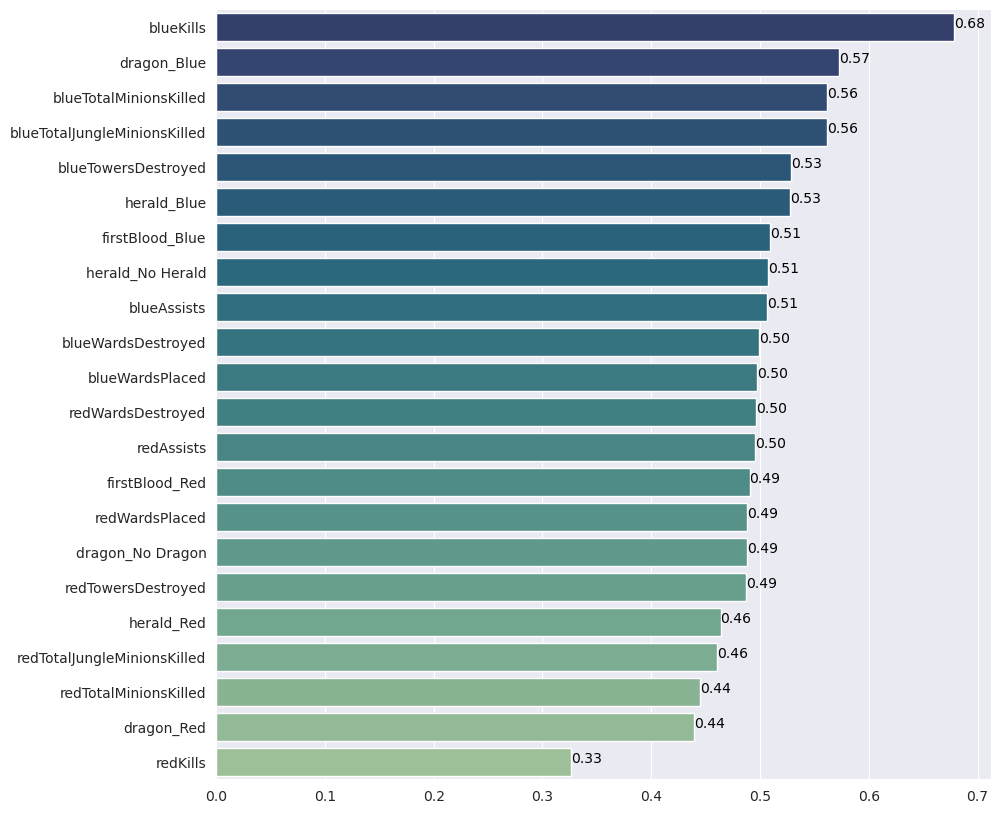

In [48]:
# Initiate model
model = LogisticRegression(random_state=8)
model.fit(X_train_coeff, y_train)

# Return list of coefficients
coeffs = pd.Series(model.coef_.flatten(), index=X_train_coeff.columns).sort_values(ascending=False)

# Convert to odds and to probabilities
odds = np.exp(coeffs)
probs = odds/(1+odds)

# Create probabilities plot
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 10))
    ax = sns.barplot(x=probs, y=probs.index, palette='crest_r')

# Add probs values to bar chart
for index, value in enumerate(probs):
    plt.text(value, index,
             str('%.2f' % value))

This chart shows that with any 1 standard deviation increase in each feature, all things remaining the same, the probability of blue winning would increase by that number.  For example:

In [49]:
# Calculate standard deviation of blueKills
df['blueKills'].std().round(2)

3.01

Referring to our probability graph, if blue gets 3 more kills within the first 10 minutes with all other stats between teams being equivalent, the probability that blue will win increases to 68%.

Let's check this with blueTotalMinions:

In [50]:
# Calculate standard deviation of blueTotalCreeps
df['blueTotalMinionsKilled'].std().round(2)

21.86

All things equal, if blue kills an additional ~22 minions, the probability that it will win improves from our baseline 50% to 57%.

## Random Forest

Logistic regression isn't the only tool at our disposal.  Random forests are powerful machine learning models that might help us increase the performance of our classification model.  Let's try a base model to see how it performs.

In [51]:
# Initiate a random forest model
model_rf = RandomForestClassifier(random_state=8)
model_rf.fit(X_train, y_train)

model_accuracy(model_rf)

Training Accuracy: 100.00%
Test Accuracy: 71.59%


At 100% training accuracy, it's clearly overfit.  

In [52]:
cross_val_check('Random Forest', model_rf)

Random Forest Cross Validation Scores:

[0.72543353 0.71965318 0.76589595 0.71387283 0.73265896 0.73227207
 0.70767004 0.72648336 0.72214182 0.70477569]

Cross validation mean: 	72.51%


Cross validation scores vary pretty widely, with the highest being 76.5% and the lowest being 70.4%.  

Training Accuracy: 100.00%
Test Accuracy: 71.59%

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1493
           1       0.72      0.71      0.71      1471

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



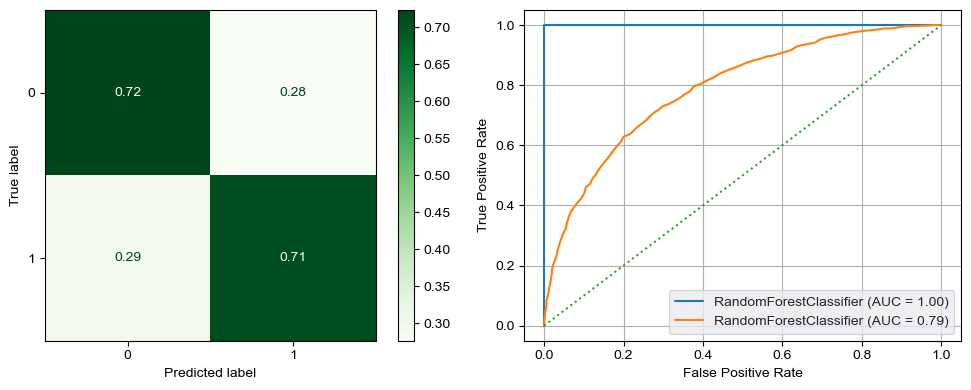

In [53]:
evaluate_model(model_rf)

Notice the blue line in the AUC curve which shows our 100% fit training data.  

### Grid Search

We can still experiment further with random forests using grid search.  We'll define a few lists of possible parameters, and scikit-learn will iterate through every combination and return the parameters that output the highest test accuracy.

In [54]:
# If run = True, code will perform full grid search
# If run = False, code will use previously calculated best parameters
run = False

# Initiate new random forest model
model_rf_hp = RandomForestClassifier(random_state=8)

# Define grid search parameters
if run == True:
    rf_param_grid = {
        'n_estimators': [10, 30, 100, 1000],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 2, 6, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]}
    
else:
    rf_param_grid = {'criterion': ['gini'],
     'max_depth': [6],
     'min_samples_leaf': [2],
     'min_samples_split': [2],
     'n_estimators': [30]}


# Run grid search and fit to train data
rf_grid_search = GridSearchCV(model_rf_hp, rf_param_grid, cv=5, 
                              verbose=100,
                              n_jobs=-1,
                              scoring='accuracy'
                             )
rf_grid_search.fit(X_train, y_train)

# Print metrics
model_compare(model_rf, rf_grid_search.best_estimator_)
print("")
print(f"Cross Validated Score: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
--- Base Model ---
Training Accuracy: 100.00%
Test Accuracy: 71.59%

--- Grid Search Model ---
Training Accuracy: 76.25%
Test Accuracy: 71.49%

Our base model outperformed our grid search model by 0.10%

Cross Validated Score: 73.84%

Optimal Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 30}


Training Accuracy: 76.25%
Test Accuracy: 71.49%

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1493
           1       0.71      0.72      0.71      1471

    accuracy                           0.71      2964
   macro avg       0.71      0.71      0.71      2964
weighted avg       0.71      0.71      0.71      2964



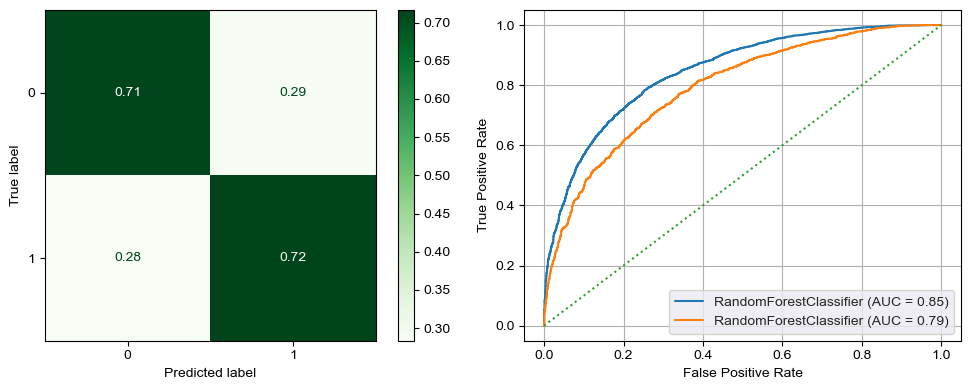

In [55]:
evaluate_model(rf_grid_search.best_estimator_, cmap='Greens')

The overfitting inherent with random forest search isn't aided too much by the grid search.

### Feature Importances

Training Accuracy: 76.25%
Test Accuracy: 71.49%


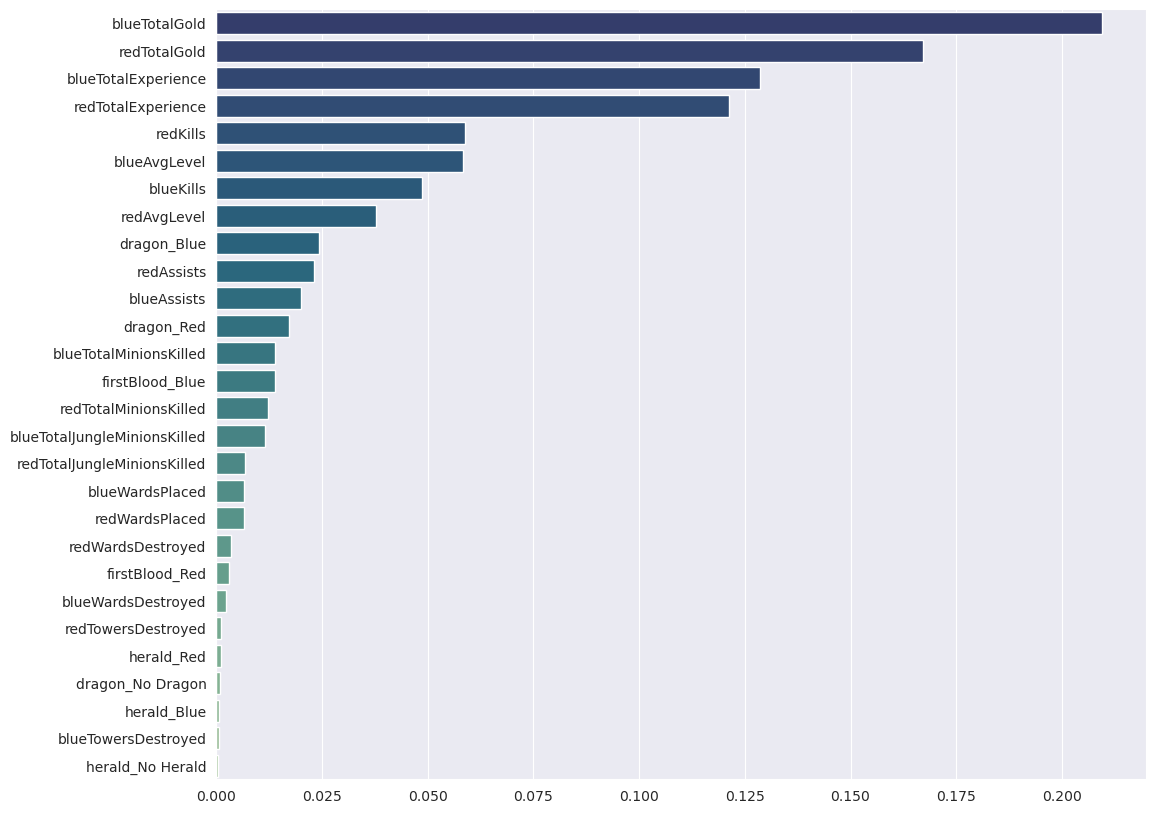

In [56]:
# Create feature importances function for Random Forest and XGboost
def plot_features(model, X_train, X_test, y_train=y_train, y_test=y_test):    
    
    # Create and fit new model
    model = model
    model.fit(X_train, y_train)
    
    # Create a list of feature importances
    feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    
    # Show model accuracy
    model_accuracy(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    
    # Plot feature importance
    with sns.axes_style("darkgrid"):
        plt.figure(figsize=(12, 10))
        ax = sns.barplot(x=feature_importance, y=feature_importance.index, palette='crest_r')

# Creating a new model for our function with grid search best parameters
rf_model = RandomForestClassifier(**rf_grid_search.best_params_, random_state=8)
    
plot_features(rf_model, X_train, X_test)


Similar to our logistic regression model, random forest with grid search believes that TotalGold is the most important indicator influencing teh outcome of a match.  Let's see how this model performs with our coefficient X_train and X_test, which focuses specifically on player actions.

Training Accuracy: 75.10%
Test Accuracy: 69.80%


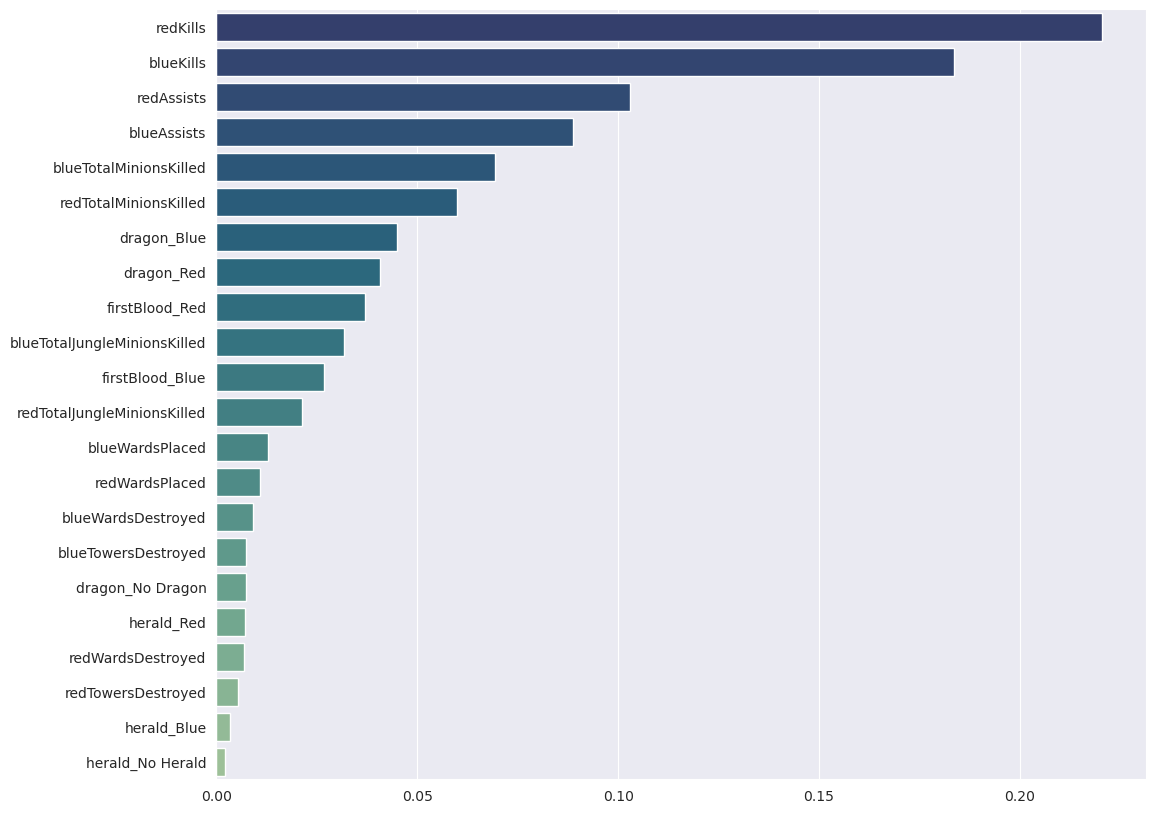

In [57]:
plot_features(rf_model, X_train_coeff, X_test_coeff)

We see similar importances from what we found in our logistic regression set.  Unfortunately this does not provide us with too much additional information.

## XGBoost

XGBoost is a very powerful model that could potentially improve our model's accuracy.  Let's give this one a go before settling on one model to make interpretations.

In [58]:
# Initiate and train XGB model
model_xgb = XGBClassifier(random_state=8)
model_xgb.fit(X_train, y_train)

model_accuracy(model_xgb)

Training Accuracy: 96.56%
Test Accuracy: 69.23%


Similar to random forest, our training data is very overfit, and our test accuracy suffers as a result.

In [59]:
cross_val_check('XGBoost', model_xgb)

XGBoost Cross Validation Scores:

[0.71965318 0.69653179 0.71531792 0.69075145 0.7066474  0.6975398
 0.7105644  0.723589   0.6845152  0.70622287]

Cross validation mean: 	70.51%


Cross validation check is less promising than our random forest model.

### Grid Search

In [60]:
# If run = True, code will perform full grid search
# If run = False, code will use previously calculated best parameters
run = False

# Instantiate new model for hyperparameter tuning
model_xgb_hp = XGBClassifier(random_state=8)

# Define grid search parameters
if run == True:
    param_grid = {
        'learning_rate': [0.0001, 0.001, 0.01, 0.1],
        'max_depth': [3, 5, 7, 9],
        'min_child_weight': [1, 2],
        'subsample': [0.5, 0.7, 1],
        'n_estimators': [10, 100, 1000]}
else:
    param_grid = {
        'learning_rate': [0.01],
        'max_depth': [5],
        'min_child_weight': [2],
        'subsample': [0.5],
        'n_estimators': [100]}

# Create grid search and train
xgb_grid_search = GridSearchCV(model_xgb_hp, param_grid, scoring='accuracy', 
                               cv=5, n_jobs=-1, verbose=100)
xgb_grid_search.fit(X_train, y_train)

# Print metrics
model_compare(model_xgb, xgb_grid_search.best_estimator_)
print("")
print(f"Cross Validated Score: {xgb_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {xgb_grid_search.best_params_}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished
--- Base Model ---
Training Accuracy: 96.56%
Test Accuracy: 69.23%

--- Grid Search Model ---
Training Accuracy: 75.84%
Test Accuracy: 71.73%

Our grid search model outperformed our base model by 2.50%

Cross Validated Score: 73.69%

Optimal Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.5}


Our grid search model performed better than our base model, but the test accuracy is still not as strong as our logistic regression model with grid search.

Training Accuracy: 75.84%
Test Accuracy: 71.73%

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1493
           1       0.71      0.72      0.72      1471

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



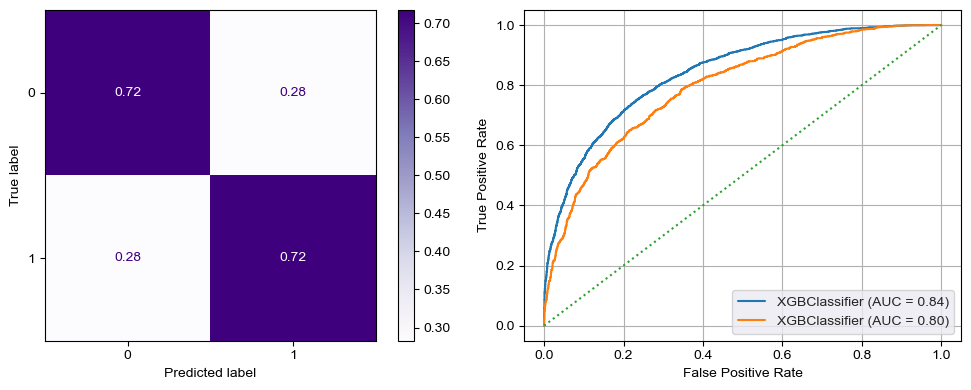

In [61]:
evaluate_model(xgb_grid_search.best_estimator_, cmap='Purples')

### Feature Importances

Training Accuracy: 75.84%
Test Accuracy: 71.73%


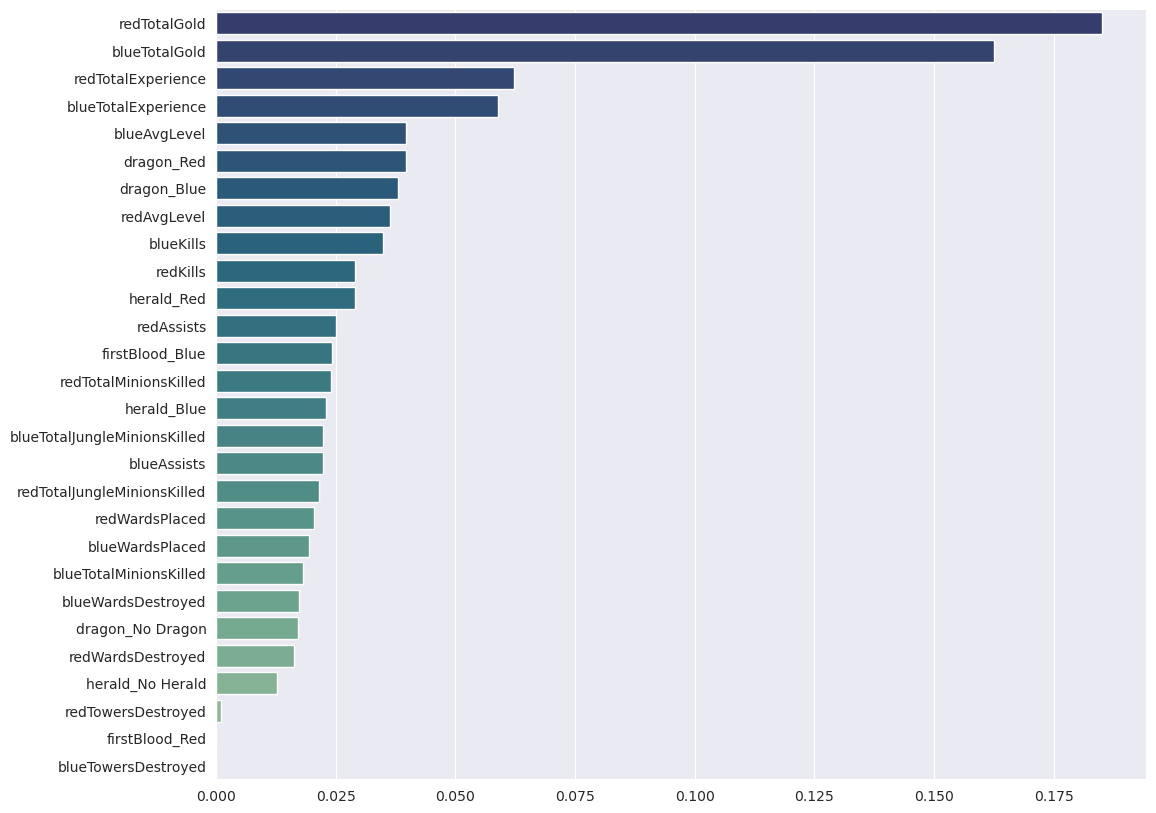

In [62]:
# Create a new model for our function with grid search best parameters
xgb_model = XGBClassifier(**xgb_grid_search.best_params_, random_state=8)

plot_features(xgb_model, X_train, X_test)

XGBoost with grid search seems to have caught on that the incidental featuers (TotalGold, TotalExperience, AvgLevel) are highly important.  Interestingly, it thinks that getting the dragon is more influential than kills, which we generally believe to not be in line with League of Legends meta.

Training Accuracy: 74.61%
Test Accuracy: 70.21%


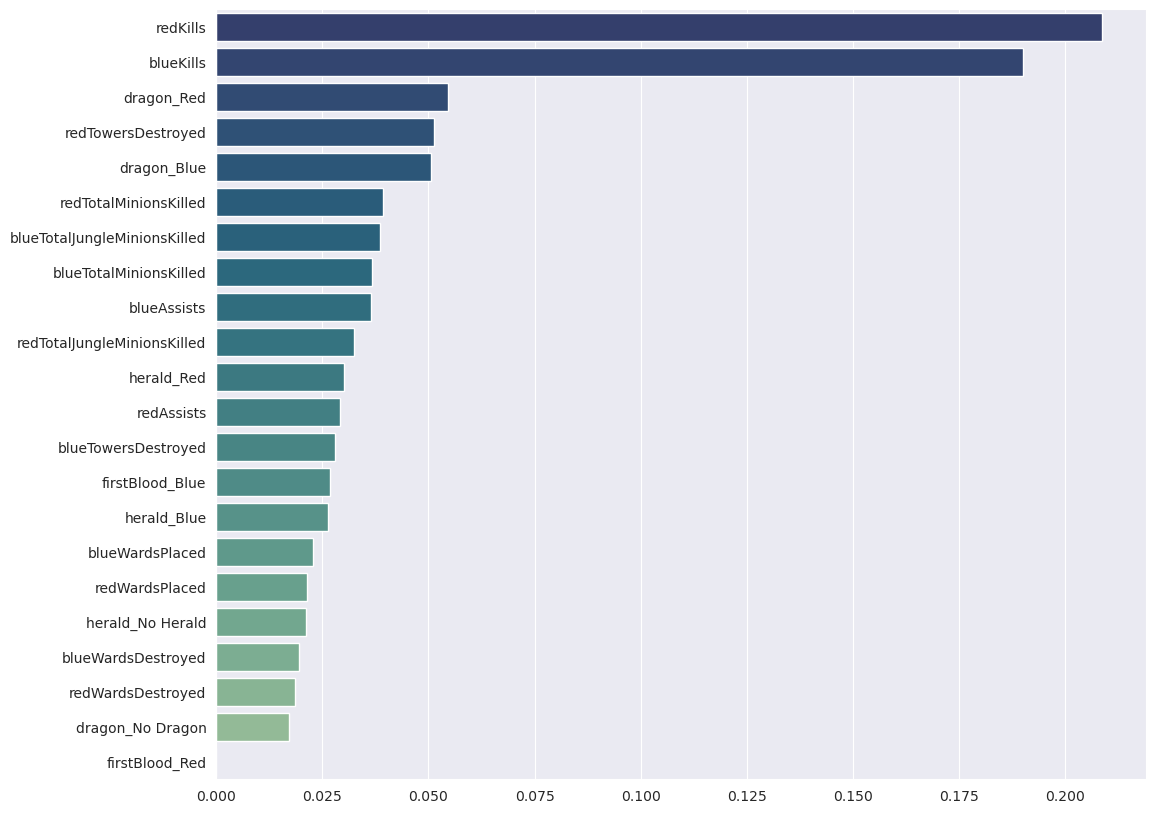

In [63]:
plot_features(xgb_model, X_train_coeff, X_test_coeff)

With our player action dataset, it is in line with other models in valuing kills most highly.  It also places redTowersDestroyed higher than previous models.  This is worth consideration.

# Interpretation

While somewhat dissappointing that we couldn't get any higher than 72.10% accuracy with any of our models, this realization is ultimately good news for the League of Legends team.  If higher accuracy could be achieved, it would indicate that the outcome of the game might rely too heavily on the first 10 minutes.  That said, it's worth considering whether or not 72% is too high.

Our best performing model was logistic regression with grid search.  An important observation from our random forest and XGBoost feature importances were that red and blue differences were somewhat uneven, which begs to question whether or not these models are appropriate for this type of dataset.

All of the models seemed to point to indicators of early success rather than the actions players can take.  In all models, TotalGold, TotalExperience, and AvgLevel took very high if not highest feature importance.  Interestingly, when we removed these features from our dataset, accuracy did not suffer more than 2-3%.  

In terms of what actions are most valuable, TotalKills, TotalMinionsKilled, TotalJungleMinionsKilled, and defeating the dragon are most important.

# Conclusions and Recommendations

The goal of this project was to determine whether or not Riot should consider balancing the game based on our findings.  Ultimately, we could not find any glaring issues with overweighted feature importance.  The fact that none of our machine learning models could best 72% accuracy in predicting the winner is a sign that the first 10 minutes is not overtly important, but is 72% too high?  

Would something like 60-65% make for a more engaging player experience and encourage players to finish strong throughout the match?

It's also important to understand that this data was pulled from the most skilled players in League of Legends online matchmaking.  LoL's most core audience would not likely react too positively to strong shifts catering towards newer players.

We propose the following questions to League of Legends developers for consideration:

- Is 72% predictive quality too high for the first 10 minutes of League of Legends?
- Are kills too heavily weighted in terms of actions that players take?
- Could tinkering with buffs granted by dragon and herald lead to changes in predictive quality?
- Are gold rewards too high in the early game?
- Most importantly, what amount of predictive quality is desirable for the best player experience, both for those winning and those losing?

For future analysis, we would recommend running this dataset with the exact same matches from this dataset but with 20 minutes and 30 minutes of data to see how predictive quality changes.  Would predictive quality improve, or would it stay the same?  Also, more elements would be introduced at that point, and those additional features should be taken into consideration as well.

We would also ask the League of Legends staff where the true issues are with their current playerbase.  Are the highly skilled players content, but newer players less so?  Is new player retention equal, higher, or lower priority than keeping their dedicated fans happy?  There is likely no best answer to this question.  Tinkering with games that have a loyal fanbase is a delicate and sometimes detrimental act, and it would be helpful to understand the history of game modifications and player approval before recommending anything formal.